# Identifying Complex Faraday Sources with Keras

In this notebook we'll illustrate how to train a convolutional neural network (CNN) to classify our synthetic Faraday dispersion spectra as being simple or complex. This will involve looking at our data generator, training our network architecture, and evaluating the network performance by comparing how the accuracy is related to the following:

- signal-to-noise (S/N) ratio
- amplitude ratio of the two sources $(|P_2| / |P_1|)$
- offset in Faraday depth $(\Delta \phi)$
- offset in phase angle $(\Delta \chi)$.

## Modules

We'll begin by importing all the methods we'll need in one place. We'll also define a boolean parameter `run_training` and `run_testing` that specifies whether to train and test the network so as to avoid repeating these operations each time the notebook is executed. The network weights and testing data will be saved to allow for easy loading.

In [1]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.metrics import precision_recall_curve, roc_curve
from possum.coverage import ASKAP12
from possum.cnn import classifier
from possum.datagen import datagen, generateParams

run_training:bool = True # Whether to run training in this notebook.
run_testing:bool = True # Whether to run testing in this notebook.

## Data Generator

Our README.md file provided an overview of how we generate our Faraday spectra. For training we'll make use of our data generation function `datagen`. Let's begin by looking at its documentation

In [2]:
datagen?

Signature:
datagen(
    nu: numpy.ndarray,
    phi: numpy.ndarray,
    batch: int = 32,
    seed: bool = None,
    noise_function: Optional[<built-in function callable>] = <function addPolarizationNoise at 0x7f8ecd920280>,
    noise_kwargs: dict = {},
    transform: Optional[<built-in function callable>] = None,
    yield_params: bool = False,
    **kwargs,
) -> Tuple[numpy.ndarray, Union[numpy.ndarray, dict]]
Docstring:
Generator that yields a Faraday spectrum and either the 
class label or the parameter dictionary.

Parameters
----------
nu : np.ndarray
    A set of wavelengths over which to calculate the polarization

phi : np.ndarray
    The range of Faraday depths

batch : int
    The number of object instance to create in each mini-batch

seed : int, optional
    A random number seed for reproducibility. Optional.

noise_function : callable, optional
    A function for adding noise to the Polarization spectrum.
    It should take as input the polarization and any arguments
    co

Our `datagen` function requires us to pass along the arguments `nu` and `phi`, which correspond to the frequency coverage (in Hz) and the Faraday depths (in rad/m$^2$) we would like to use for generating our synthetic data.

By default, `datagen` will return the Faraday dispersion as complex values. The `transform` argument can be used to transform these values, such as changing the value to have a channel associated with the real and imaginary components or taking the absolute value. Using just the absolute value results in the quickest increase in accuracy, so we'll use that for our transformation in this notebook.

`datagen` also has routines for adding noise to the polarization spectrum. The defaults are set up for adding white noise with a standard deviation over the range (0,1), but the function is flexible enough so that we can really add any kind of noise generating function by setting the `noise_function`, `noise_kwargs`, and `noise_generator` parameters. The later argument is associated with the function `generateParams` and is passed through the `**kwargs` arguments.

More detail about generating random parameter values can be found in `generateParams`, so why don't we have a look at its documentation:

In [3]:
generateParams?

Signature:
generateParams(
    size: int,
    amplitude_generator: <built-in function callable> = <function <lambda> at 0x7f8ecd920550>,
    chi_generator: <built-in function callable> = <function <lambda> at 0x7f8ecd9205e0>,
    depth_generator: <built-in function callable> = <function <lambda> at 0x7f8ecd920670>,
    noise_generator: Dict[str, <built-in function callable>] = {'sigma': <function <lambda> at 0x7f8ecd920700>},
    p_complex: float = 0.5,
    seed: Optional[int] = None,
) -> Dict[str, numpy.ndarray]
Docstring:
Generates a set of parameters of the given size

Parameters
----------
size : int
    The number of Faraday sources to generate parameters for

amplitude_generator : callable
    Function that takes as input a size parameter and returns
    a numpy array of random amplitude values of the specified
    size. Note that this function is only applied to the second
    component, thus it should return a value between 0 and 1 to
    ensure the first component is the prim

The `generateParams` function generates parameter values for the `chi`, `depth`, and `amplitude` parameters for creating a polarization spectrum as well as a `label` indicating whether a source in simple or complex. The array will feature a pair of `chi`, `depth`, and `amplitude` values for each complex sample, while only a single value for each will be associated with each for simple sources. The noise parameters can be generated by setting `noise_generator` to be a dictionary whose keys are parameter names associated with `noise_function` and whose values are functions that take as input a size parameter and return a sequence of random elements of the specified size (e.g., a sequence of random kernels for Gaussian processes). We'll keep the noise arguments to be their default values.

We'll be using the ASKAP-12 frequency coverage while a Faraday depth range of (-100,100) should be a good range to consider. Why don't we go ahead and create these parameters. We'll also create a data generator for our training data and use it to generate data for validation purposes. Additionally, we'll allow the range of Faraday depths to span our coverage, but favoring values closer to zero than the ends of the distribution by using the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). This way we can avoid having a hard cutoff at a specific Faraday depth for our sources.

In [4]:
nu = ASKAP12()
phi = np.arange(-100,101)
transform=np.abs
depth_generator = lambda size: -100+200*np.random.beta(2,2,size)

train_data = datagen(nu=nu, phi=phi, batch=64, transform=transform, seed=123, depth_generator=depth_generator)
valid_data = next(iter(train_data))

## Network

For constructing a network we have a helper class in `classifier`. The class contains methods for adding layers to the network with each method call adding the specified operation to the model. Why don't we have a look at its documentation:

In [5]:
classifier?

Init signature: classifier(channels: int, width: Optional[int] = None)
Docstring:     
Simple model architecture that allows for easily adding
additional layers through function calls. Assumes a channels
last format.

Parameters
----------
channels:int
    The number of input channels

width: int, optional
    The size of the 1D tensor

Methods
-------
activation(act, **kwargs)
    Adds an activation function to the model sequence.

batchNorm(**kwargs)
    Adds an batch normalization operation to the model sequence.

compile(loss, metrics, optimizer, weights)
    Adds a final dense and activation layer for the output and compiles
    the model.

conv(filters, kernel_size, **kwargs)
    Adds a convolution operation to the model sequence.

dense(neurons, **kwargs)
    Adds a dense operation to the model sequence.

dropout(drop, **kwargs)
    Adds a dropout operation to the model sequence.

flatten()
    Adds a flatten operation to the model sequence

hidden(neurons, drop, activation, dep

The class takes two inputs: `channels` and `width`. The `channels` variable refers to the number of image channels, so if we just pass in the absolute value of our Faraday spectrum then there is only one channels while if we pass in the real and imaginary components then there would be two input channels. The width parameter refers to the length of the input spectrum. Unless we are applying a flattening operation, we can leave it as `width=None`, but it might be nice to pass along to specify what size the network was trained with.

In our paper we used a model featuring inception layers from the GoogLeNet model [(Szegedy et al., 2014)](https://arxiv.org/abs/1409.4842), which was one of the state of the art architectures at the time. We also used a flattening operation followed by several dense operations, although these no longer tend to be found in model architectures due to their large number of parameters and proneness to overfitting. We'll keep the inception layers in our model while replacing the flattening operation with global max pooling (which takes the maximum value in each channel). Let's go ahead and create our model architecture and visualize it using Keras' `plot_model` function:

In [6]:
def get_filters(i):
    return 16*(i+1)

n_conv = 2; n_inception = 3

cnn = classifier(channels=1) # Only using the absolute value, so there is only 1 input filter
for i in range(n_conv):
    cnn.conv(get_filters(i), kernel_size=3)
    cnn.batchNorm()
    cnn.activation('relu')
    cnn.conv(get_filters(i), kernel_size=3, strides=2)
for i in range(n_inception):
    cnn.inception(conv=[3,5], pool=[2], filters=get_filters(i+n_conv))
    cnn.conv(get_filters(i+n_conv), kernel_size=3, strides=2)
cnn.conv(filters=100)
cnn.globalPooling(max_pool=True)
cnn.dropout(0.5)
cnn.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-5, momentum=0.9))

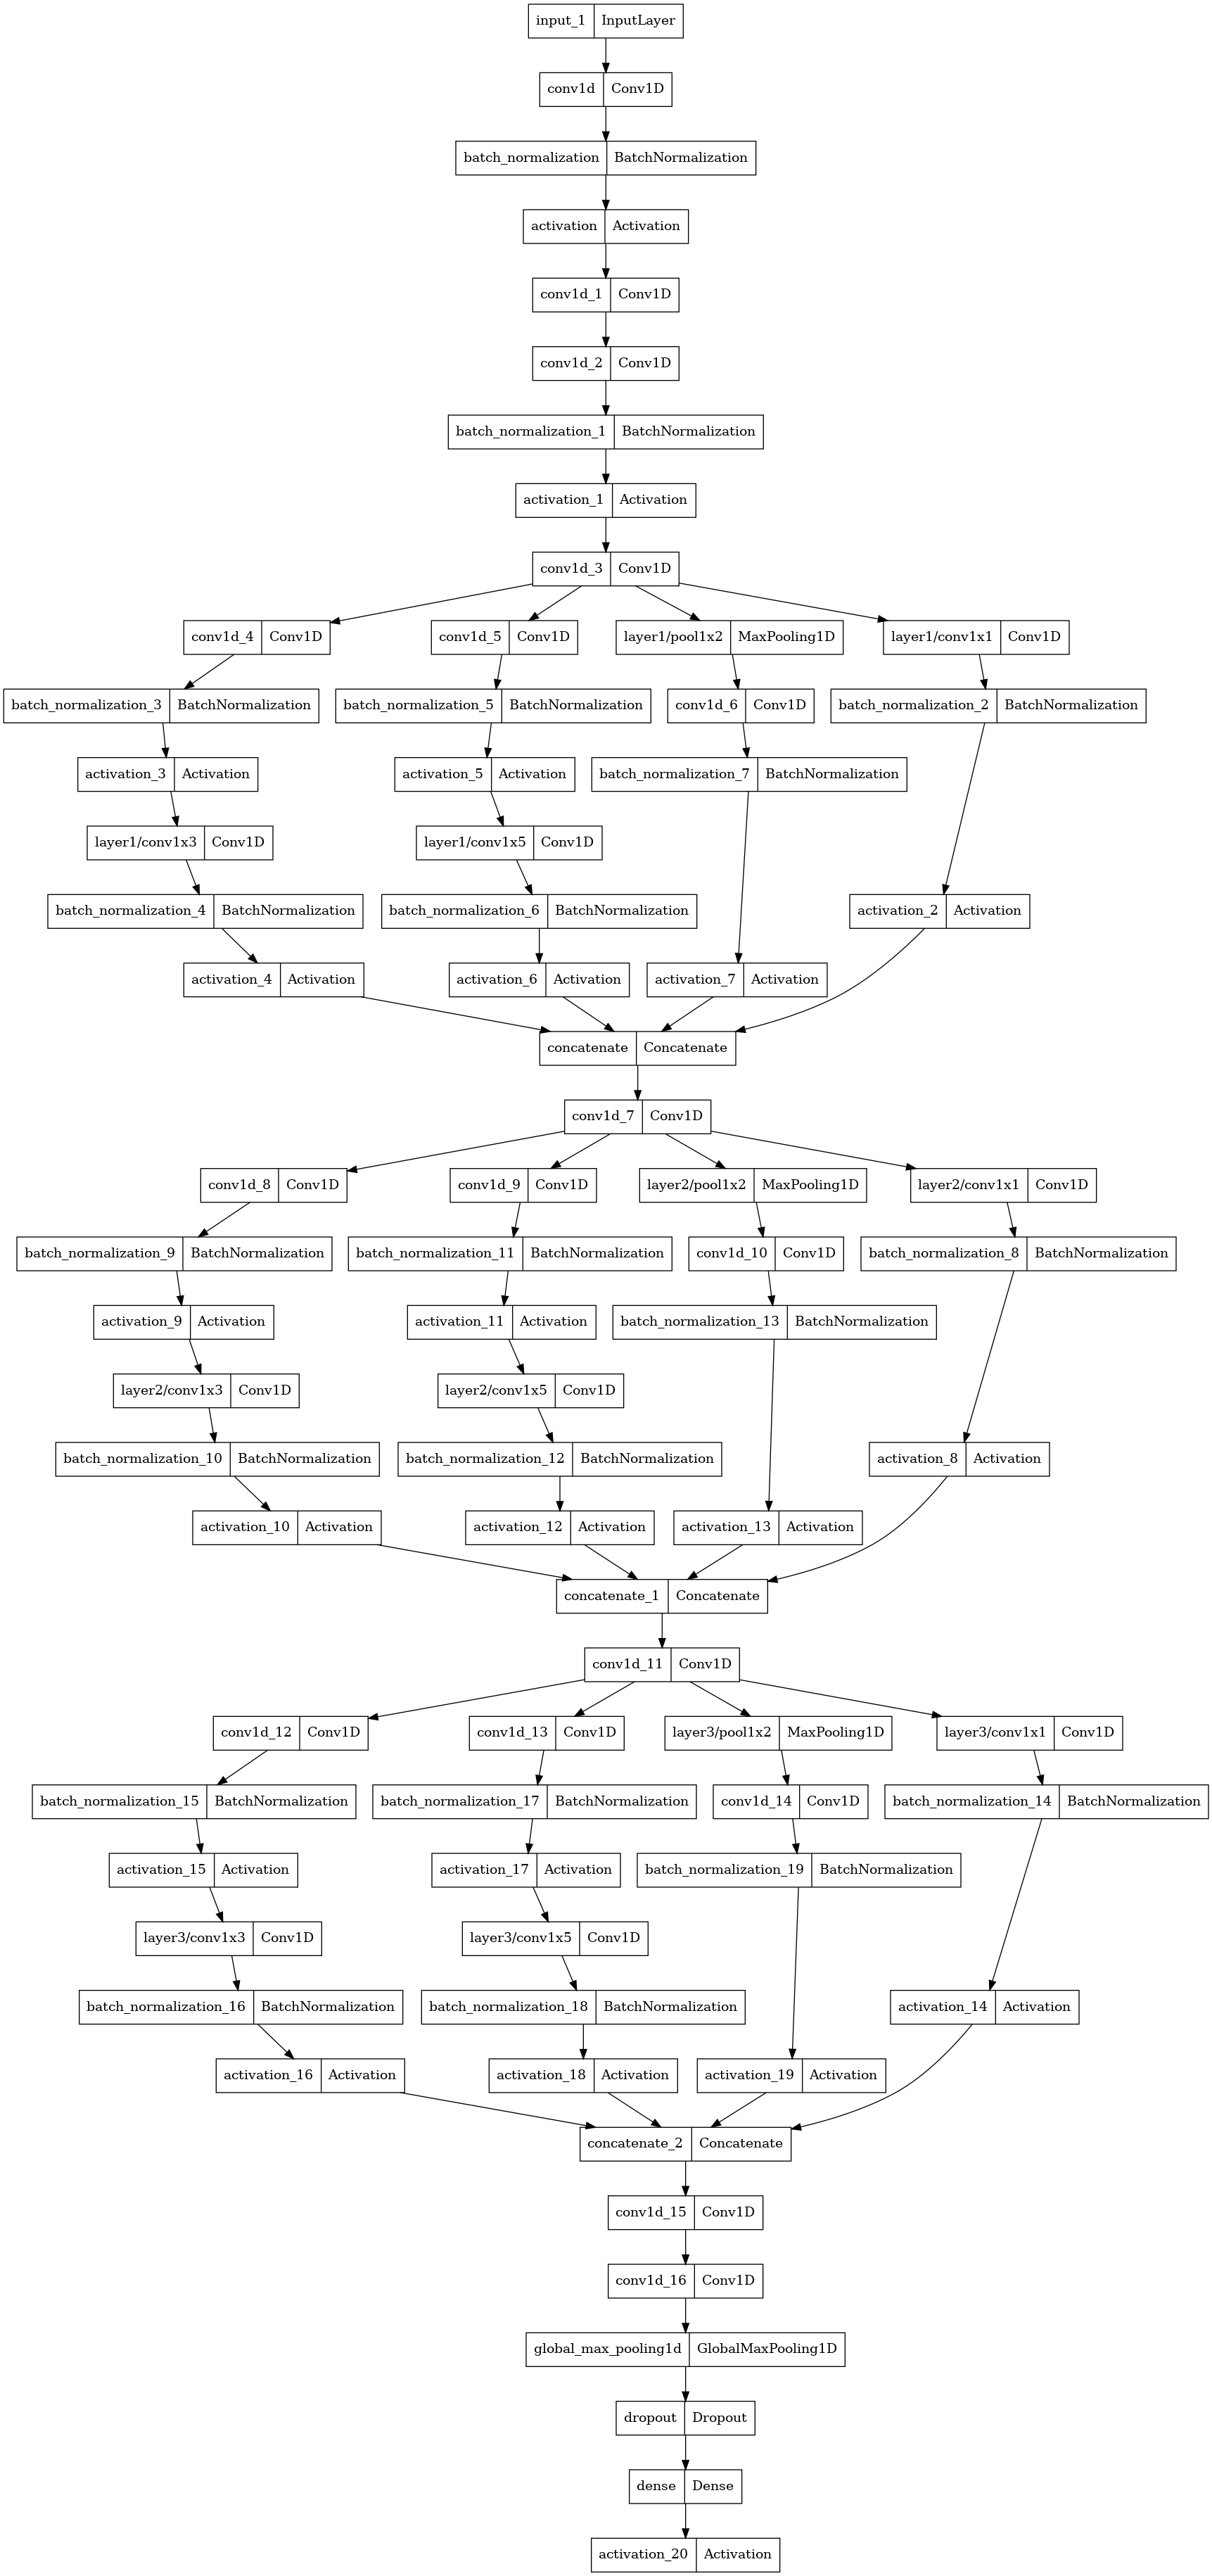

In [7]:
tf.keras.utils.plot_model(cnn.model, os.path.join('figures', 'model.png'))

With only a few lines of code we were able to create a rather complicated network architecture with about 250,000 parameters:

In [8]:
cnn.model.count_params()

244345

## Training

Rather than generate a fixed training dataset, we can utilize our `datagen` function to generate a random batch at each call so that the network never sees the same data twice and is able to explore the full parameters space. With our batch size of 64 samples, let's define an "epoch" as consisting of 16 batches and train for up to 100 epochs. We'll add a model checkpoint and logger callback to save our model weights and training results and also add an early stoppage callback as well. Our model can then be trained and the weights loaded as follows:

In [9]:
log_file = os.path.join('log', 'train_log.csv')
wgt_file = os.path.join('log', 'model_weights')

if run_training:
    cnn.model.fit(
        x=train_data,
        validation_data=valid_data,
        steps_per_epoch=16,
        epochs=100,
        callbacks=[
            tf.keras.callbacks.CSVLogger(log_file),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=wgt_file, 
                save_weights_only=True,
                save_best_only=False,
                monitor='loss',
                mode='min',
            ),
            #f.keras.callbacks.EarlyStopping(
            #   monitor='loss',
            #   patience=15,
            #   min_delta=0.001,
            #)
        ],
    )

cnn.model.load_weights(wgt_file)

Epoch 1/100
16/16 [==============================] - 14s 746ms/step - loss: 0.7254 - binary_accuracy: 0.6074 - val_loss: 0.7010 - val_binary_accuracy: 0.4844
Epoch 2/100
16/16 [==============================] - 12s 748ms/step - loss: 0.4804 - binary_accuracy: 0.7842 - val_loss: 0.7286 - val_binary_accuracy: 0.4844
Epoch 3/100
16/16 [==============================] - 12s 732ms/step - loss: 0.3922 - binary_accuracy: 0.8428 - val_loss: 0.7963 - val_binary_accuracy: 0.4844
Epoch 4/100
16/16 [==============================] - 13s 829ms/step - loss: 0.3428 - binary_accuracy: 0.8506 - val_loss: 0.8512 - val_binary_accuracy: 0.4844
Epoch 5/100
16/16 [==============================] - 13s 837ms/step - loss: 0.3208 - binary_accuracy: 0.8701 - val_loss: 0.8833 - val_binary_accuracy: 0.4844
Epoch 6/100
16/16 [==============================] - 13s 806ms/step - loss: 0.3154 - binary_accuracy: 0.8682 - val_loss: 0.9751 - val_binary_accuracy: 0.4844
Epoch 7/100
16/16 [==============================] -

Let's open up the training log and look at the last few entries:

In [10]:
log = pd.read_csv(log_file)
log.tail()

,epoch,binary_accuracy,loss,val_binary_accuracy,val_loss
95,95,0.920898,0.225093,0.937500,0.153548
96,96,0.903320,0.256702,0.968750,0.207308
97,97,0.911133,0.233465,0.953125,0.165758
98,98,0.926758,0.196229,0.937500,0.169537
99,99,0.918945,0.216595,0.953125,0.162856


It looks like we were getting an accuracy just above 90%. Let's go ahead and visualize our training log:

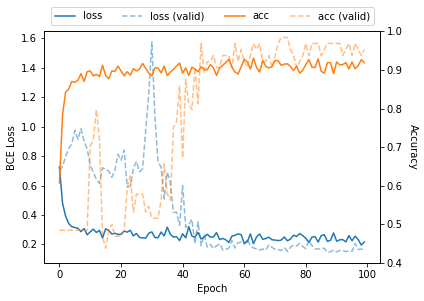

In [11]:
colors = [plt.get_cmap('tab10')(i) for i in range(2)]

fig, ax = plt.subplots()
ax.plot(log['epoch'], log['loss'], label='loss', color=colors[0], linestyle='-')
ax.plot(log['epoch'], log['val_loss'], label='loss (valid)', color=colors[0], linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('BCE Loss')

ax2 = ax.twinx()
ax2.plot(log['epoch'], log['binary_accuracy'], label='acc', color=colors[1])
ax2.plot(log['epoch'], log['val_binary_accuracy'], label='acc (valid)', color=colors[1], linestyle='--', alpha=0.5)
ax2.set_ylim(0.4, 1.0)
ax2.set_ylabel('Accuracy', rotation=-90, labelpad=15)
ax2.set_ylim(0.4,1)

fig.legend(bbox_to_anchor=(0,.05,1,1), loc='upper center', ncol=4)
fig.tight_layout()

The training data quickly rose up to around 90% accuracy in about 10 epochs with the loss starting to flatten out there as well. There is still a bit of a downward trend to the loss, so continuing to train would likely continue to improve the model performance as we don't really need to worry about overfitting since the network isn't seeing recycled data.

Our validation data, despite being drawn from the same population as our training data, shows a considerably worse performance in the early stages and doesn't really catch up to the training performance until around 50 epochs. This discrepancy is likely related to batch normalization. The normalization is calculated on each minibatch during training, but it uses the average training value when testing. Thus the lag in validation performance likely reflects the time it takes for the network to stabilize its weights. The better performance on the validation data at the end of the training likely reflects the fact that we are only using one minibatch of data.

With a decent model now trained, let's go ahead and generate a large amount of testing data and examine where our network tends to make mistakes in separating simple and complex sources.

## Testing

For testing, let's use `datagen` to create a new generator function. We'll also set `yield_params=True` so that we have access to the parameters to examine how the network performance is dependent on them.

In [12]:
test_data = datagen(
    nu=nu,
    phi=phi,
    batch=100,
    transform=transform,
    yield_params=True,
    seed=4567,
    depth_generator=depth_generator
)

We can now iterate through our testing dataset and generate the model predictions using our model's `predict` method for testing purposes. With a batch size of 100, we generate 100 minibatches for a sample size of 10,000 sources to evaluate the network. Rather than having to generate the data each time this notebook is run, we'll also store our testing data using `dill.dump` and load it again with `dill.load`:

In [13]:
test_file = os.path.join("log", "testing.pkl")

if run_testing:
    test_gen = iter(test_data)

    data = {}
    for i in range(100):
        # Get new batch of data
        X,y = next(test_gen)

        # Insert items in noise dictionary into params
        for k,v in y.pop('noise').items():
            y[k] = v

        # Generate model predictions
        y['p'] = cnn.model.predict(X)

        # Store data and model predictions
        for k,v in y.items():
            if k not in data:
                data[k] = []
            data[k].extend(v)

    data = {k:np.asarray(v, dtype='object') for k,v in data.items()}
    with open(test_file, 'wb') as f:
        dill.dump(data, f)

with open(test_file, 'rb') as f:
    data = dill.load(f)

A popular means of evaluating a classifier's performance is by looking at a ROC curve or a precision-recall curve, the later of which tends to be more popular when the true cases as less common and the former when the classes are more evenly balanced.

The ROC curve compares the true positive rate (TRP; also called recall) against the false positive rate (FPR). TPR is the fraction of true cases that were correctly identified

$$
TPR = \frac{TP}{TP + FN}
$$

while the false positive rate compares the number of true cases falsely classified as negative compared to the number of false cases that were correctly identified:

$$
FPR = \frac{FN}{FN + TN}
$$

The precision measures the fraction of predicted true cases that are correctly classified

$$
Prec = \frac{TP}{TP + FP}
$$

To calculate these quantities for various cutoff thresholds, we can use`precision_recall_curve` and `roc_curve` from scikit-learn:

In [14]:
pred = data['p'].astype('float'); true = data['label'].astype('int')
precision, recall, thresh_pr = precision_recall_curve(true, pred, pos_label=1)
fpr, tpr, thresh_ft = roc_curve(true, pred)

We can now generate our ROC and precision-recall curves. We'll also select a couple probability thresholds and plot their location on the curves

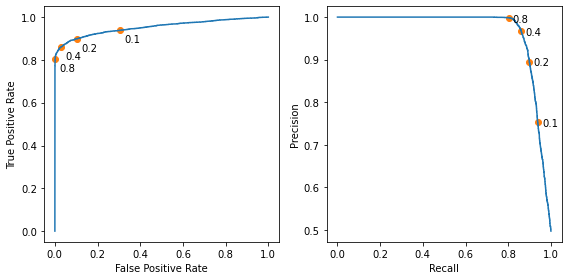

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

ax[0].plot(fpr, tpr)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].plot(recall, precision)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

for t in [0.1, 0.2, 0.4, 0.8]:
    loc = np.argmin(abs(thresh_ft - t))
    ax[0].scatter(fpr[loc], tpr[loc], color='tab:orange')
    ax[0].text(fpr[loc]+0.02, tpr[loc]-0.02, t, ha='left', va='top')
    
    loc = np.argmin(abs(thresh_pr - t))
    ax[1].scatter(recall[loc], precision[loc], color='tab:orange')
    ax[1].text(recall[loc]+0.02, precision[loc], t, ha='left', va='center_baseline')

fig.tight_layout()

Our model does a fairly good job at separating simple and complex sources. There seems to be fairly clean population cutoff for complex sources when $p=0.8$ that achieves a false positive rate of about 0% while still capturing 80% of our complex sample.

The optimal cutoff will of course depend on other considerations as well, such as how many false negatives a study wants to tolerate for those only interested in simple sources.

### Complex Sources

Now that we have a general overview of the model performance, let's look a bit deeper and see how the performance on complex sources is related to the parameters used to generate our synthetic spectra. We can begin by extracting only the testing samples that consist of complex sources:

In [16]:
mask = data['label'] == 1
complex_data = {
    k:v[mask]
    for k,v in data.items()
}

Next we'll generate some quantites of interest, such as the amplitude ratio $|P_{2}|/|P_{1}|$ of the secondary source to the primary, the offset $\Delta\phi$ in Faraday depths, the offset $\Delta\chi$ in polarization angle, and the relative amount of noise $\sigma / |P_{1}|$. For the polarization, we'll want to measure the angular offset, so we'll go ahead and define a function to calculate this quantity and utilize it to generate our various measures:

In [17]:
def angular_offset(x,y):
    offset = np.exp(1j*(x-y))
    return abs(np.angle(offset))

measures = {
    'p': complex_data['p'],
    'amp_ratio': [x[1] for x in complex_data['amplitude']],
    'depth_offset': [abs(x[0] - x[1]) for x in complex_data['depth']],
    'chi_offset': [angular_offset(x[0], x[1]) for x in complex_data['chi']],
    'sigma': complex_data['sigma'].clip(min=0.01),
}
measures = {k:np.asarray(v).squeeze().astype('float') for k,v in measures.items()}

Let's begin by examining how each of our measures correlates with the network's probability prediction:

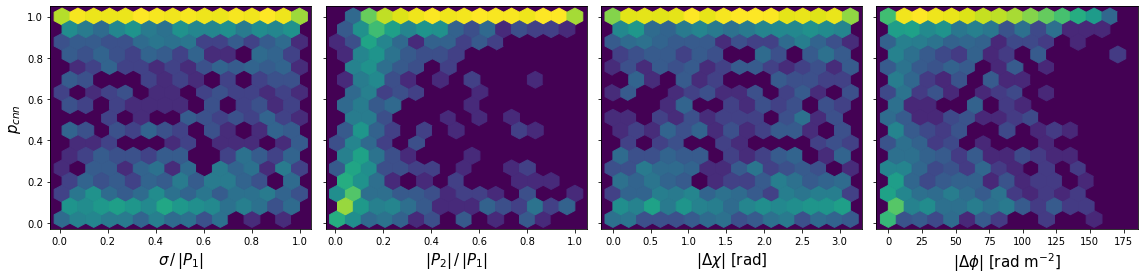

In [59]:
pkwargs = {'bins': 'log', 'gridsize': 15, 'cmap': plt.cm.viridis, 'mincnt': None}
lkwargs = {'fontsize': 15}

fig, ax = plt.subplots(ncols=4, figsize=(16,4), sharey=True)

ax[0].hexbin(x=measures['sigma'], y=measures['p'], **pkwargs)
ax[0].set_xlabel(r'$\sigma \, / \, |P_{1}|$', **lkwargs)
ax[0].set_ylabel(r'$p_{cnn}$', **lkwargs)

ax[1].hexbin(measures['amp_ratio'], measures['p'], **pkwargs)
ax[1].set_xlabel(r'$|P_{2}| \, / \, |P_{1}|$', **lkwargs)

ax[2].hexbin(measures['chi_offset'], measures['p'], **pkwargs)
ax[2].set_xlabel(r'$|\Delta\chi|$ [rad]', **lkwargs)

ax[3].hexbin(measures['depth_offset'], measures['p'], **pkwargs)
ax[3].set_xlabel(r'$|\Delta\phi|$ [rad m$^{-2}$]', **lkwargs)

for a in ax:
    a.set_facecolor(pkwargs['cmap'](0))

fig.tight_layout()
#fig.savefig("figures/network_heatmap.png")

There's not a whole lot of correlation between the noise level and the accuracy, with perhaps only a slight suggestion of values approaching 0.5 at larger noise levels. The white noise nature does help to minimize the effects of noise as the polarization spectrum still generally retains a good portion of its shape, so our results suggest we could probably increase the noise level even more to work with sources at even lower S/N ratios. However, surveys like POSSUM will generally apply some S/N cutoff like 3 or 5 when creating a source catalog, so very noisy spectra are unlikely to be relevant for the network's performance.

The most noteable association is the performance on the amplitude ratio, with the performance beginning to degrade when the amplitude of the secondary source starts to go below 1/5 of the primary source.

There is little dependence of the network on the angular offset in the polarization angle.

The network performance does display have some association with the offset in Faraday depths, where the network stuggles to predict sources whose Faraday depths are close to being the same. This isn't all that surprising, since for these cases the sources can effectively be considered as a single source.

Given that the performance seems to be most closely tied to the amplitude ratio and offset in Faraday depth, why don't we go ahead and directly compare the performance as a function of both by computing the average network probability in each spatial bin:

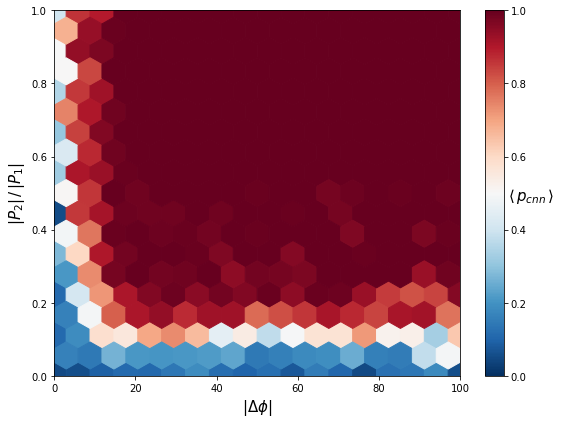

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
c = ax.hexbin(measures['depth_offset'], measures['amp_ratio'], measures['p'], gridsize=17, cmap=plt.cm.RdBu_r, extent=(0,100,0,1), vmin=0, vmax=1)
cbar = fig.colorbar(c, ax=ax)
cbar.set_label(r'$\langle \, p_{cnn} \, \rangle$', rotation=0, fontsize=15, va='center_baseline')
ax.set_xlabel(r'$|\Delta \phi|$', fontsize=15)
ax.set_ylabel(r'$|P_2| \, / \, |P_1|$', fontsize=15)
ax.set_xlim(0,100)
ax.set_ylim(0,1)
fig.tight_layout()
#fig.savefig("figures/network_heatmap_amplitude_depth.png")

As expected, we see the network does a really good job at identifying sources when the two components are more similar in their amplitudes and have distinct Faraday depths. The determining quantity is predominantly the amplitude ratio of the sources with a cutoff around $|P_{2}|/|P_{1}| \approx 0.1$ largely serving to separate complex sources that are detectable from those that aren't.

There appears to be a slight trend in that as the Faraday depth separation grows, a larger amplitude ratio is required to detect two component sources. This could be due to the secondary source winding up in a noisier region being so far away from the primary source. It could also be a training artifact in that the network sees large separations less frequently than smaller ones, so it's slightly less successful at classifying these cases.